# Introduction
- distance とその統計量  
- cos features  
- dist_interact  
nb29 で作成した、`fc`を使用する  
さらに、`fc` とその他の特徴量の掛け算の特徴量を作る

# Import everything I need :)

In [1]:
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
# from fastprogress import progress_bar
import warnings

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 33
isSmallSet = False
length = 200000

In [3]:
pd.set_option('display.max_columns', 200)
warnings.filterwarnings('ignore')

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/nb29_fc_train_feature.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
# fc_train
path = file_path + 'nb29_fc_train_feature.csv'
if isSmallSet:
    fc_train = pd.read_csv(path)[:length]
else:
    fc_train = pd.read_csv(path)

In [9]:
# fc_test
path = file_path + 'nb29_fc_test_feature.csv'
if isSmallSet:
    fc_test = pd.read_csv(path)[:length]
else:
    fc_test = pd.read_csv(path)

In [10]:
# train dist-interact
path = file_path + 'nb33_train_dist-interaction.csv'
if isSmallSet:
    dist_interact_train = pd.read_csv(path)[:length]
else:
    dist_interact_train = pd.read_csv(path)

In [11]:
# test dist-interact
path = file_path + 'nb33_test_dist-interaction.csv'
if isSmallSet:
    dist_interact_test = pd.read_csv(path)[:length]
else:
    dist_interact_test = pd.read_csv(path)

In [12]:
len(test), len(fc_test)

(2505542, 2505542)

In [13]:
len(train), len(fc_train)

(4658147, 4658147)

In [14]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [15]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [16]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

**dist-interact**

In [17]:
train['dist_interact'] = dist_interact_train.values
test['dist_interact'] = dist_interact_test.values

**basic**

In [18]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df


for atom_idx in [0,1]:
    train = map_atom_info(train, structures, atom_idx)
    test  = map_atom_info(test, structures, atom_idx)
    
    train = train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})
    test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [19]:
def create_type0(df):
    df['type_0'] = df['type'].apply(lambda x : x[0])
    return df

distances

In [20]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    return df

# train = distances(train)
# test  = distances(test)

distance 統計量

In [21]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    return df

angle features

In [22]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance', 'dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    return df

def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df



In [23]:
%%time

print('add fc')
print(len(train), len(test))
train['fc'] = fc_train.values
test['fc']  = fc_test.values

print('type0')
print(len(train), len(test))
train = create_type0(train)
test  = create_type0(test)

print('distances')
print(len(train), len(test))
train = distances(train)
test  = distances(test)

print('create_featueres')
print(len(train), len(test))
train = create_features(train)
test  = create_features(test)

print('create_closest')
print(len(train), len(test))
train = create_closest(train)
test  = create_closest(test)

print('add_cos_features')
print(len(train), len(test))
train = add_cos_features(train)
test  = add_cos_features(test)

add fc
4658147 2505542
type0
4658147 2505542
distances
4658147 2505542
create_featueres
4658147 2505542
create_closest
4658147 2505542
add_cos_features
4658154 2505542
CPU times: user 1min 25s, sys: 1min 57s, total: 3min 22s
Wall time: 3min 22s


---
LabelEncode
- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [24]:
for f in ['atom_1', 'type_0', 'type']:
    if f in train.columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

---
`fc` とその他の特徴量の掛け合わせ  
もちろん、カテゴリカルなデータにはかけあわせない

In [25]:
# train

# 掛け算をおこなわないint型を取得
idx = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1).dtypes == np.int
int_type = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1).columns.values[idx]
int_type = ['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'] + int_type.tolist()
print(f"int型: {int_type}")

# do it
for feat in train.drop(int_type, axis=1):
    train[f'{feat} * fc'] = train[feat] * train['fc']

int型: ['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant', 'atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0', 'molecule_couples', 'atom_0_couples_count', 'atom_1_couples_count', 'atom_index_closest_0', 'atom_index_closest_1']


In [26]:
# test

# 掛け算をおこなわないint型を取得
idx = test.drop(['id', 'molecule_name', 'atom_0'], axis=1).dtypes == np.int
int_type = test.drop(['id', 'molecule_name', 'atom_0'], axis=1).columns.values[idx]
int_type = ['id', 'molecule_name', 'atom_0'] + int_type.tolist()
print(f"int型: {int_type}")

# do it
for feat in test.drop(int_type, axis=1):
    test[f'{feat} * fc'] = test[feat] * test['fc']

int型: ['id', 'molecule_name', 'atom_0', 'atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0', 'molecule_couples', 'atom_0_couples_count', 'atom_1_couples_count', 'atom_index_closest_0', 'atom_index_closest_1']


---
**show features**

In [27]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,dist_interact,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,fc,type_0,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,dist_interact * fc,x_0 * fc,y_0 * fc,z_0 * fc,x_1 * fc,y_1 * fc,z_1 * fc,fc * fc,dist * fc,dist_x * fc,dist_y * fc,dist_z * fc,molecule_dist_mean * fc,molecule_dist_min * fc,molecule_dist_max * fc,molecule_atom_index_0_x_1_std * fc,molecule_atom_index_0_y_1_mean * fc,molecule_atom_index_0_y_1_mean_diff * fc,molecule_atom_index_0_y_1_mean_div * fc,molecule_atom_index_0_y_1_max * fc,molecule_atom_index_0_y_1_max_diff * fc,molecule_atom_index_0_y_1_std * fc,molecule_atom_index_0_z_1_std * fc,molecule_atom_index_0_dist_mean * fc,molecule_atom_index_0_dist_mean_diff * fc,molecule_atom_index_0_dist_mean_div * fc,molecule_atom_index_0_dist_max * fc,molecule_atom_index_0_dist_max_diff * fc,molecule_atom_index_0_dist_max_div * fc,molecule_atom_index_0_dist_min * fc,molecule_atom_index_0_dist_min_diff * fc,molecule_atom_index_0_dist_min_div * fc,molecule_atom_index_0_dist_std * fc,molecule_atom_index_0_dist_std_diff * fc,molecule_atom_index_0_dist_std_div * fc,molecule_atom_index_1_dist_mean * fc,molecule_atom_index_1_dist_mean_diff * fc,molecule_atom_index_1_dist_mean_div * fc,molecule_atom_index_1_dist_max * fc,molecule_atom_index_1_dist_max_diff * fc,molecule_atom_index_1_dist_max_div * fc,molecule_atom_index_1_dist_min * fc,molecule_atom_index_1_dist_min_diff * fc,molecule_atom_index_1_dist_min_div * fc,molecule_atom_index_1_dist_std * fc,molecule_atom_index_1_dist_std_diff * fc,molecule_atom_index_1_dist_std_div * fc,molecule_atom_1_dist_mean * fc,molecule_atom_1_dist_min * fc,molecule_atom_1_dist_min_diff * fc,molecule_atom_1_dist_min_div * fc,molecule_atom_1_dist_std * fc,molecule_atom_1_dist_std_diff * fc,molecule_type_0_dist_std * fc,molecule_type_0_dist_std_diff * fc,molecule_type_dist_mean * fc,molecule_type_dist_mean_diff * fc,molecule_type_dist_mean_div * fc,molecule_type_dist_max * fc,molecule_type_dist_min * fc,molecule_type_dist_std * fc,molecule_type_dist_std_diff * fc,x_closest_0 * fc,y_closest_0 * fc,z_closest_0 * fc,x_closest_1 * fc,y_closest_1 * fc,z_closest_1 * fc,distance_0 * fc,distance_1 * fc,cos_0_1 * fc,cos_0 * fc,cos_1 * fc
0,0,dsgdb9nsd

In [28]:
print(len(test.columns))
print(test.columns)

159
Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'dist_interact', 'atom_0', 'x_0', 'y_0', 'z_0',
       ...
       'y_closest_0 * fc', 'z_closest_0 * fc', 'x_closest_1 * fc',
       'y_closest_1 * fc', 'z_closest_1 * fc', 'distance_0 * fc',
       'distance_1 * fc', 'cos_0_1 * fc', 'cos_0 * fc', 'cos_1 * fc'],
      dtype='object', length=159)


# create train, test data

In [29]:
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)
y = train['scalar_coupling_constant']
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)

X = train.copy()
X_test = test.copy()

assert len(X) == len(X_test), f'X と X_test のサイズが違います X: {X.shape[1]}, X_test: {X_test.shape[1]}'

Mem. usage decreased to 5397.47 Mb (5.7% reduction)
Mem. usage decreased to 2884.09 Mb (5.7% reduction)


AssertionError: X と X_test のサイズが違います X: (4658154, 156), X_test: (2505542, 156)

In [30]:
del train, test

In [31]:
gc.collect()

35

# Training model

**params**

In [32]:
# Configuration
TARGET = 'scalar_coupling_constant'
# CAT_FEATS = ['type']
N_ESTIMATORS = 1500
VERBOSE = 300
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error
N_JOBS = multiprocessing.cpu_count() -1

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


In [33]:
n_folds = 4
folds = KFold(n_splits=n_folds, shuffle=True)

In [34]:
# init

def train_lgb(X, X_test, y, lgb_params, folds,
              verbose, early_stopping_rounds, n_estimators):

    result_dict = {}
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    models = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print('------------------')
        print(f'- fold{fold_n + 1}' )
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        

        # Train the model
        model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=N_JOBS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # predict
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   
        y_test_pred = model.predict(X_test)

        oof[valid_idx] = y_valid_pred.reshape(-1,)  # oof: out of folds
        scores.append(mean_absolute_error(y_valid, y_valid_pred))

        prediction += y_test_pred

        # feature_importance
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X.columns
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    # result
    prediction /= folds.n_splits
    feature_importance["importance"] /= folds.n_splits
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = feature_importance


    print('------------------')
    print('====== finish ======')
    print('score list:', scores)
    X['scalar_coupling_constant'] = y
    cv_score = kaggle_metric(X, oof)
#     X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
    print('CV mean score(group log mae): {0:.4f}'.format(cv_score))

    
    return result_dict, cv_score

In [35]:
%%time
# train
result_dict, cv_score = train_lgb(X=X, X_test=X_test, y=y, lgb_params=lgb_params, folds=folds,
                        verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                        n_estimators=N_ESTIMATORS)

X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)

------------------
- fold1
Fold 1 started at Wed Jul 31 04:54:33 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 0.609086	valid_1's l1: 0.63473
[600]	training's l1: 0.581333	valid_1's l1: 0.628931
[900]	training's l1: 0.558416	valid_1's l1: 0.624366
[1200]	training's l1: 0.538713	valid_1's l1: 0.620293
[1500]	training's l1: 0.521414	valid_1's l1: 0.617176
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.521414	valid_1's l1: 0.617176
------------------
- fold2
Fold 2 started at Wed Jul 31 05:41:40 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 0.609576	valid_1's l1: 0.637263
[600]	training's l1: 0.581264	valid_1's l1: 0.630801
[900]	training's l1: 0.558014	valid_1's l1: 0.626331
[1200]	training's l1: 0.53806	valid_1's l1: 0.622077
[1500]	training's l1: 0.520579	valid_1's l1: 0.618773
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.520579	valid_1's l1: 0.61877

## plot feature importance

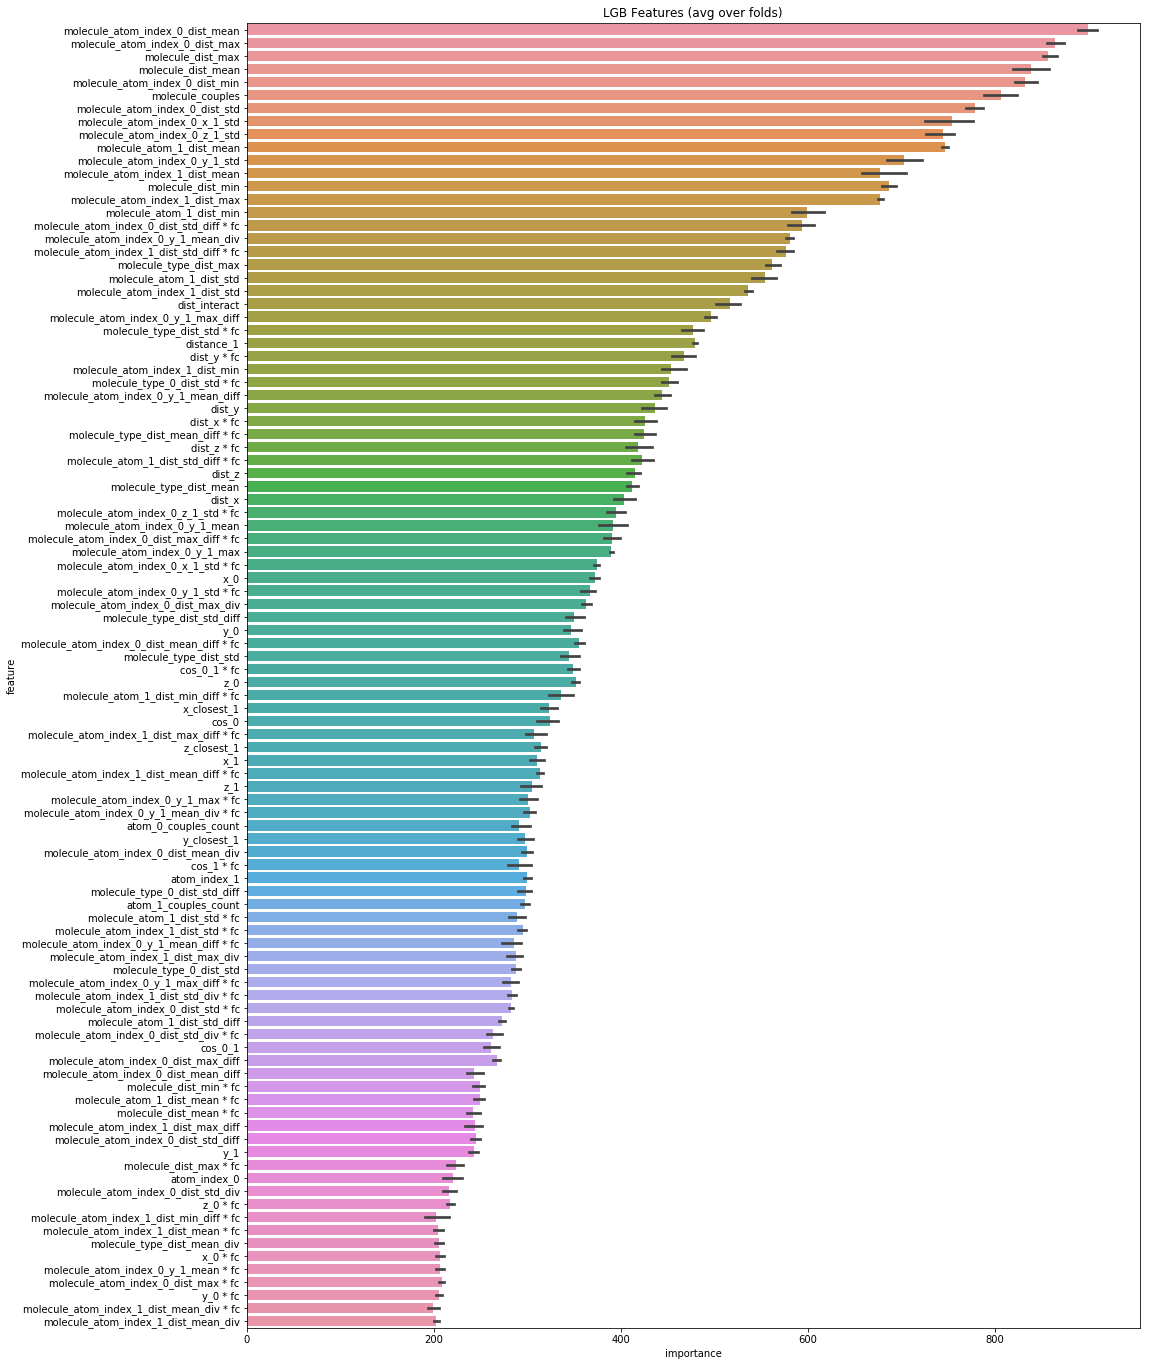

In [52]:
# top n features
top_n = 100

feature_importance = result_dict['feature_importance']
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:top_n].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 24));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

# Save

**submission**

In [37]:
path_submittion = '../output/' + 'nb{}_submission_lgb_{:.3f}.csv'.format(nb, cv_score)
# path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_submittion}')

save pash: ../output/nb33_submission_lgb_-0.771.csv


In [38]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[:100]
# submittion['scalar_coupling_constant'] = result_dict['prediction']
submittion['scalar_coupling_constant'] = result_dict['prediction']
submittion.to_csv(path_submittion, index=False) if not isSmallSet else print('using small set')

---
**result**

In [39]:
path_oof = '../output/' + 'nb{}_oof_lgb_{:.3f}.csv'.format(nb, cv_score)
print(f'save pash: {path_oof}')

save pash: ../output/nb33_oof_lgb_-0.771.csv


In [40]:
# oof = pd.DataFrame(X_short['oof'])
oof = pd.DataFrame(result_dict['oof'])
oof.to_csv(path_oof, index=False) if not isSmallSet else print('using small set')

# analysis

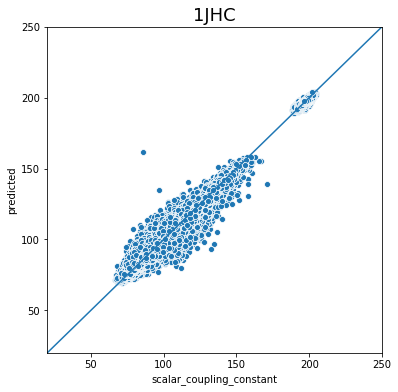

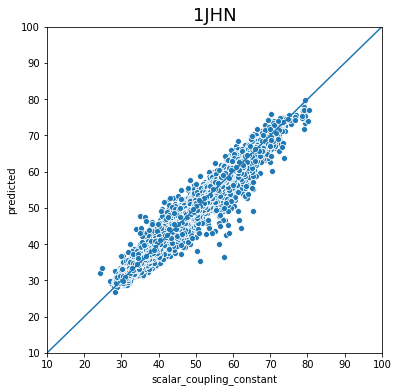

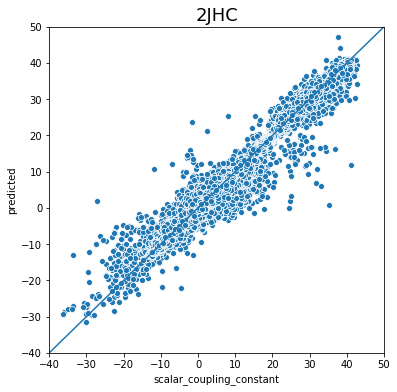

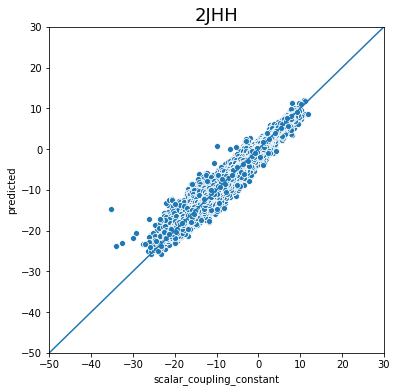

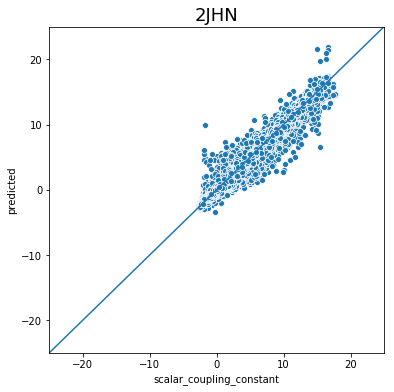

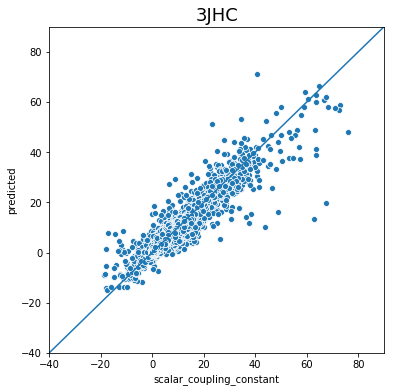

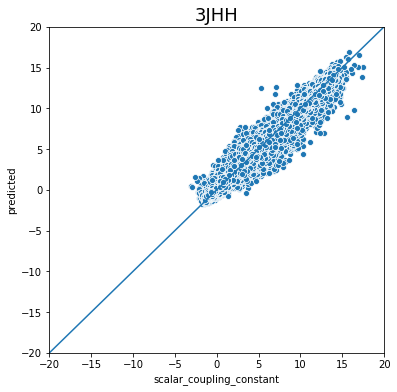

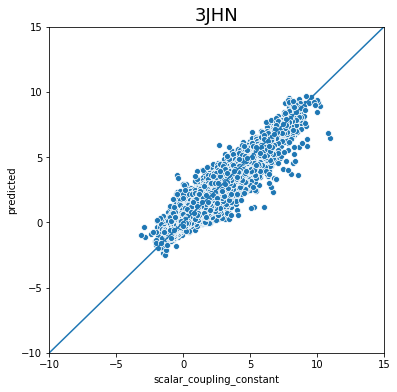

In [44]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 20, 250)
plot_oof_preds('1JHN', 10, 100)
plot_oof_preds('2JHC', -40, 50)
plot_oof_preds('2JHH', -50, 30)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -40, 90)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)